# Porter Case Study

Build a regression model using Neural Networks to estimate delivery times for Porter, India's largest intra-city logistics marketplace. By analyzing features such as market location, order protocol, item details, and partner availability, this study seeks to improve customer experience by providing accurate delivery estimates. The report details the exploratory data analysis, feature engineering, model architecture, and performance evaluation.





**Data Dictionary**

market_id : integer id for the market where the restaurant lies

created_at : the timestamp at which the order was placed

actual_delivery_time : the timestamp when the order was delivered

store_id	: encoded id for different stores

order_protocol	: integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, prebooked, third part etc)

total_items	subtotal	: final price of the order

num_distinct_items	: the number of distinct items in the order

min_item_price	: price of the cheapest item in the order

max_item_price	: price of the costliest item in order

total_onshift_partners	: number of delivery partners on duty at the time order was placed

total_busy_partners	: number of delivery partners attending to other tasks

total_outstanding_orders	: total number of orders to be fulfilled at the moment

estimated_store_to_consumer_driving_duration : approximate travel time from restaurant to customer



In [17]:
#for reding and handling the data
import pandas as pd
import numpy as np
import os

#for visualizing and analyzing it
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Ann training
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


In [2]:
!gdown 1WFa46c7_uSZ6GSzgYrDk4TKJd3y9zv8f

Downloading...
From: https://drive.google.com/uc?id=1WFa46c7_uSZ6GSzgYrDk4TKJd3y9zv8f
To: /content/data_2.csv
100% 15.7M/15.7M [00:00<00:00, 54.2MB/s]


In [3]:
df = pd.read_csv("data_2.csv")
df.drop(['estimated_store_to_consumer_driving_duration'], axis=1, inplace=True)
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
dtypes: float64(5), int64(6), object(2)
memory us

In [6]:
#converting date fields from object to datetime

df['created_at']= pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  float64       
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  int64         
 4   order_protocol            175777 non-null  float64       
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 8   min_item_price            175777 non-null  int64         
 9   max_item_price            175777 non-null  int64         
 10  total_onshift_dashers     175777 non-null  float64       
 11  total_busy_dashers        175777 non-null  float64       
 12  to

In [7]:
#Target variable
#convert total time taken into minutes
df['delivery_time_minutes']=(df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

#Feature Engineering
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.day_of_week
df['is_weekend'] = df['order_dayofweek'].isin([5,6]).astype(int)
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_time_minutes,order_hour,order_dayofweek,is_weekend
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,47.0,22,4,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,44.0,21,1,0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,55.0,0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,59.0,3,3,0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,46.0,2,1,0


In [8]:
#drop leakage columns
df.drop(['created_at','actual_delivery_time'], axis=1, inplace=True)
df

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_time_minutes,order_hour,order_dayofweek,is_weekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,47.0,22,4,0
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,44.0,21,1,0
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,55.0,0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,59.0,3,3,0
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,46.0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175772,1.0,28,4.0,3,1389,3,345,649,17.0,17.0,23.0,43.0,0,1,0
175773,1.0,28,4.0,6,3010,4,405,825,12.0,11.0,14.0,62.0,0,4,0
175774,1.0,28,4.0,5,1836,3,300,399,39.0,41.0,40.0,46.0,4,5,1
175775,1.0,58,1.0,1,1175,1,535,535,7.0,7.0,12.0,45.0,18,6,1


In [9]:
#define features and target
X = df.drop('delivery_time_minutes', axis=1)
Y = df['delivery_time_minutes']


In [10]:
#identify feature types
categorical_features = [
    "market_id",
    "store_primary_category",
    "order_protocol"
]

numerical_features = [
    "total_items",
    "subtotal",
    "num_distinct_items",
    "min_item_price",
    "max_item_price",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "order_hour",
    "order_dayofweek",
    "is_weekend"
]


In [12]:
#split data into train and test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=42)

In [21]:
#for all categorical features we are doing one hot encoding as it is best scenario for now it does provide any ordinality for our data
#for numerical features scaling we are using StandardScaling
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features)
    ]
)

In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

In [23]:
# now create model structure
model = Sequential([
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

In [24]:
model.compile(loss='mse', optimizer="adam", metrics=['mse', 'mae'])

In [25]:
from sklearn.base import validate_data
history = model.fit(
    X_train_processed,Y_train,
    validation_data = (X_val_processed, Y_val),
    epochs = 20,
    batch_size = 256
    )

Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 699.3911 - mae: 19.0302 - mse: 699.3911 - val_loss: 26.9992 - val_mae: 4.0739 - val_mse: 26.9992
Epoch 2/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 27.5647 - mae: 3.9996 - mse: 27.5647 - val_loss: 23.3523 - val_mae: 3.8173 - val_mse: 23.3523
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 23.1249 - mae: 3.7940 - mse: 23.1249 - val_loss: 22.0255 - val_mae: 3.6857 - val_mse: 22.0255
Epoch 4/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 21.8920 - mae: 3.6983 - mse: 21.8920 - val_loss: 21.3875 - val_mae: 3.6597 - val_mse: 21.3875
Epoch 5/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 21.0867 - mae: 3.6243 - mse: 21.0867 - val_loss: 20.8706 - val_mae: 3.6038 - val_mse: 20.8706
Epoch 6/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 20.6632 - mae: 3.5890 - mse: 20.6632 - val_loss: 20.8522 - val_mae: 3.5892 - val_mse: 20.8522
Epoch 7/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 20.4595 - mae

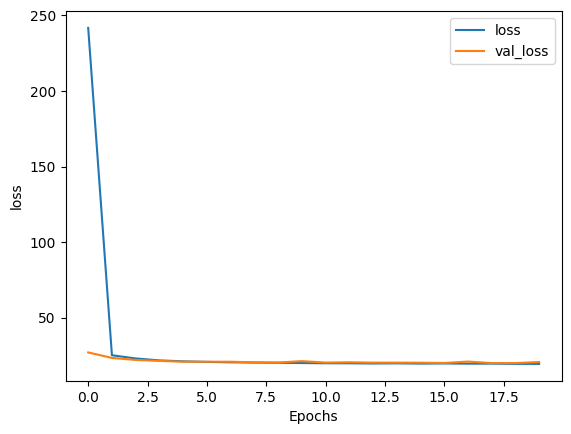

In [26]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')

In [28]:
model.evaluate(X_test_processed, Y_test)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 20.4188 - mae: 3.5727 - mse: 20.4188


[20.692678451538086, 20.692678451538086, 3.6010591983795166]

In [32]:
z= model.predict(X_test_processed)
z
r2_score(Y_test, z)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


0.7635859297742841

Prediction for a base line model

In [33]:
baseline_pred = np.full_like(Y_test, Y_train.mean())
r2_score(Y_test, baseline_pred)

-1.949257641142843e-05

Because the baseline model has an R² close to zero, while my neural network achieves an R² of ~0.76, indicating substantial improvement over naive prediction.

**MAE: ~3.6 minutes**

**R²: ~0.76**

**Baseline R²: ~0.00**

**Conclusion: Model captures real delivery-time dynamics**